### Segmenting a reservoir's response to a simple signal in time.
### Uses KMeans with reservoir sates being the points. Groups of reservoir states are clusters. Their conceptors are the centroids. Assignments are done using prediction. States that are close in time more likely to be in the same cluster as a gaussian filter is applied to the distances.

### Kmeans helpers

In [1]:
from enum import Enum


class Method(Enum):
    RANDOM = 0
    RANGES = 1
    EQUAL_SPLIT = 2

def assign_to_clusters(nb_points, nb_clusters, method=Method.EQUAL_SPLIT, limits=[]):
    """
    Assigns points to conceptors according to one of several assignment methods
    """
    assignments = [ [] for _ in range(nb_clusters) ]
    if method == Method.RANDOM or method == Method.EQUAL_SPLIT:
        points = [ x for x in range(nb_points) ]
        if method == Method.RANDOM:
            np.random.shuffle(points)
        for i in range(nb_clusters):
            assignments[i] = points[i*int(nb_points/nb_clusters):(i+1)*int(nb_points/nb_clusters)]
    elif method == Method.RANGES:
        mark = 0
        for i in range(nb_points):
            if i in limits:
                mark += 1
            assignments[mark].append(i)
    return assignments

def assign_fuzzy_to_clusters(nb_points, nb_clusters, transition_time):
    """
    Distributes points over clusters smoothly changing float membership
    """
    assignments = [ [] for _ in range(nb_clusters) ]
    mean_length = int(nb_points/nb_clusters)
    current = -1
    for t in range(nb_points):
        if not t % mean_length:
            current += 1
        for i in range(nb_clusters):
            if i == current:
                if t % mean_length > mean_length - transition_time and not i + 1 == nb_clusters:
                    assignments[i].append(1 - (t % mean_length - (mean_length - transition_time)) * 1 / transition_time)
                else:
                    assignments[i].append(1)
            elif i == current + 1 and t % mean_length > mean_length - transition_time:
                assignments[i].append((t % mean_length - (mean_length - transition_time)) * 1 / transition_time)
            else:
                assignments[i].append(0)
    return assignments

### Kmeans

In [2]:
def kmeans(X, nb_conceptors, method, limits, aperture, max_epochs=100, sigma=1):
    """
    Kmeans algorithm, adapted to conceptors
    """
    # Initial assignments and initial conceptors
    nb_points = X.shape[1]
    new_assignments = assign_to_clusters(nb_points, nb_conceptors, method, limits)
    # Training loop
    for epoch in range(max_epochs):
        print("epoch:",epoch)
        # recompute centroids based on subset of assigned state
        Cs = [ compute_c(X[:,assignments], aperture) for assignments in new_assignments ]
        Cs = optimize_apertures(Cs)
        Ns = Ns_from_Cs(Cs)
        plot.add_new_assignment_plot(new_assignments, length=nb_points)

        # recompute assignments by find the closest conceptor for each of the state points
        old_assignments = new_assignments.copy()
        new_assignments = [ [] for _ in range(nb_conceptors) ]

        Es = np.zeros((nb_conceptors, nb_points))
        for t in range(nb_points):
            Es[:,t] = np.array( evidences_for_Cs_z(X[:,t], Cs, Ns) )

        for c in range(nb_conceptors):
            Es[c,:] = gaussian_filter(Es[c,:], order=0, sigma=sigma)

        for t in range(nb_points):
            conceptor_index = np.argmax(Es[:,t])
            new_assignments[ conceptor_index ].append(t)

        # stop if converged
        for new_assignment, old_assignment in zip(new_assignments, old_assignments):
            if set(new_assignment) == set(old_assignment):
                print("Converged")
                return Cs, new_assignments

    return Cs, new_assignments

### Plotting

Generating signals
epoch: 0
Computing gammas...
Optimal gamma:  280.31187029201897
epoch: 1
Computing gammas...
Optimal gamma:  182.0727425522052
epoch: 2
Computing gammas...
Optimal gamma:  156.4090227591373
Converged


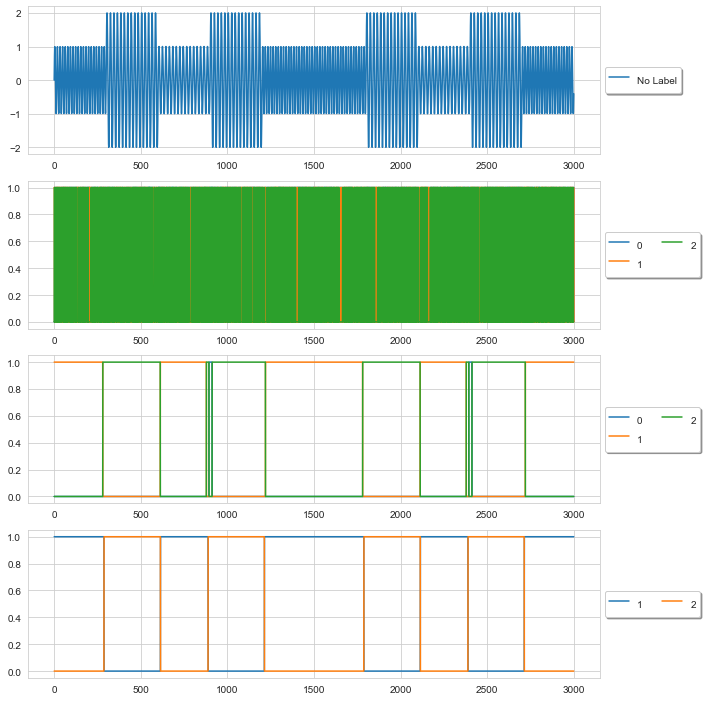

In [4]:
from lib.plotting.plot_1 import Plot
from scipy.ndimage import gaussian_filter

from scipy import linalg
inv = linalg.inv
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('/Users/joris/Documents/Work/thesis/Bachelor-Thesis/Code/hierarchical-clustering/kmeans.ipynb'))))

from lib.esn import ESN
from lib.conceptors import *

plot = Plot(10,10)

########################################
# Hyperparameters

np.random.seed(0)
t_max = 300
t_washout = 0
aperture = 5

esn_params = {
    "in_dim": 1,
    "out_dim": 1,
    "N": 50,
    "W_in_scale": 1.5,
    "b_scale": .2,
    "spectral_radius": 1.5,
    "weights": 0.1
}

########################################
# collect data

def gen_signal(n, period, amplitude):
    """
    Generates a sin wave
    """
    ts = np.arange(n)
    data = amplitude * np.sin(2 * np.pi * (1/period) * ts)
    return data

def gen_square(n, period):
    ts = np.zeros(n)
    for t in range(n):
        ts[t] = -1+2*(t % (period * 2) < period)
    return ts

print("Generating signals")
p1 = gen_signal(t_max, 15, 1)
p2 = gen_signal(t_max, 20, 1)
p3 = gen_signal(t_max, 20, 2)
p4 = gen_square(t_max, 20)
data = [p1, p2, p3]
p = np.concatenate((p1,p3,p2,p3,p1,p1,p3,p2,p3,p1))
plot.add_new(p)

#######################################
# init reservoir

esn = ESN(esn_params)

X,_ = esn.run_X(p, t_washout, p.size)

#######################################

sigma = 8

Cs_kmeans, assignments_kmeans = kmeans(X, nb_conceptors=3,
                                       method=Method.RANDOM, limits=[], aperture=1, max_epochs=100, sigma=sigma)
plot.finalize()